In [88]:
import pandas as pd
import main
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [107]:
data=pd.read_csv("C:/Users/vamsi/OneDrive/Desktop/Documents/studies/complete stock market predictor/Stock-Market-Predictor/project_root/data/Analysed_and_enhanced_data.csv")

In [108]:
data

,time,open,high,low,close,tick_volume,real_volume,ATR,result,Supertrend_Direction,RSI,MACD,MACD_signal,MACD_diff,EMA_21,Day of the week,Is Weekend,Month,hour,high_liquidity
0,2025-01-28 14:00:00,2748.979,2751.374,2748.956,2751.020,3068,0,NaN,Hold,1,NaN,NaN,NaN,NaN,2751.020000,1,False,28,14,1
1,2025-01-28 14:15:00,2750.979,2754.695,2750.074,2754.007,3240,0,NaN,Hold,1,NaN,NaN,NaN,NaN,2751.291545,1,False,28,14,1
2,2025-01-28 14:30:00,2754.041,2756.416,2752.980,2753.700,6339,0,NaN,Hold,1,NaN,NaN,NaN,NaN,2751.510496,1,False,28,14,1
3,2025-01-28 14:45:00,2753.669,2755.886,2753.263,2753.616,4654,0,NaN,Hold,1,NaN,NaN,NaN,NaN,2751.701905,1,False,28,14,1
4,2025-01-28 15:00:00,2753.647,2755.467,2751.144,2755.258,4426,0,NaN,Hold,1,NaN,NaN,NaN,NaN,2752.025187,1,False,28,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11196,2025-07-18 19:45:00,3349.397,3349.820,3347.748,3348.396,1276,0,2.158786,Hold,-1,36.676534,-0.891610,-0.389349,-0.502261,3351.838598,4,True,18,19,0
11197,2025-07-18 20:00:00,3348.359,3350.401,3347.884,3350.026,894,0,2.016929,Buy,-1,43.561901,-0.908368,-0.493153,-0.415216,3351.673817,4,True,18,20,0
11198,2025-07-18 20:15:00,3350.019,3350.655,3349.391,3349.900,683,0,1.856786,Hold,-1,43.171129,-0.921198,-0.578762,-0.342436,3351.512561,4,True,18,20,0
11199,2025-07-18 20:30:00,3349.969,3351.625,3349.078,3351.142,715,0,1.927286,Hold,-1,48.112163,-0.821675,-0.627344,-0.194330,3351.478873,4,True,18,20,0


## Na Removal and Log transform

In [109]:
data.dropna(inplace=True)

In [110]:
data.shape

(11168, 20)

In [111]:
from sklearn.preprocessing import FunctionTransformer

In [112]:
#Applying log transfrom
log_trns=FunctionTransformer(func=np.log1p)
df_deleted=data
df_deleted['ATR']=log_trns.fit_transform(data['ATR'])

<Axes: xlabel='ATR', ylabel='Count'>

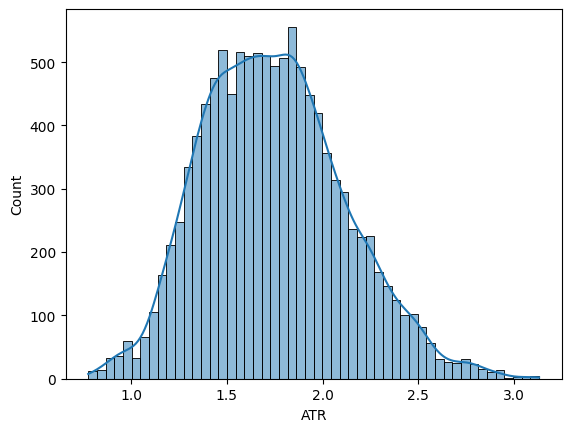

In [113]:

sns.histplot(df_deleted['ATR'],kde=True)

## Outlier Removal

In [114]:
def IQR_outlier_report(df, cols):
    report = []

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        total = df[col].shape[0]

        # Calculate percentages
        lower_pct = (df[col] < lower_bound).sum() / total * 100
        upper_pct = (df[col] > upper_bound).sum() / total * 100

        upper_diff=(df[col].max()-upper_bound)/upper_bound*100
        lower_diff=(lower_bound-df[col].min())/lower_bound*100

        report.append({
            "column": col,
            "lower_outlier_%": round(lower_pct, 2),
            "upper_outlier_%": round(upper_pct, 2),
            "upper_diff":round(upper_diff,2),
            "lower_diff":round(lower_diff,2),
            "upper_bound":upper_bound,
            "lower_bound":lower_bound,
            "maxi":df[col].max()
        })

    return pd.DataFrame(report)

In [115]:
"""
outlers are high in the the case of MACD,ATR
"""
iqr_report=IQR_outlier_report(df_deleted,["RSI","ATR","tick_volume","MACD"]) 
iqr_report


,column,lower_outlier_%,upper_outlier_%,upper_diff,lower_diff,upper_bound,lower_bound,maxi
0,RSI,0.21,0.18,4.55,26.64,85.743915,18.286693,89.643635
1,ATR,0.00,0.85,14.15,-9.46,2.741734,0.709466,3.129804
2,tick_volume,0.00,6.93,267.88,130.59,6143.625000,-1049.375000,22601.000000
3,MACD,3.43,2.77,73.77,-155.90,9.271627,-8.379281,16.111468


In [116]:
def hybrid_outler_removal(df, cols, extreme_thresh=2):
    clean_df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        lower_extreme = Q1 - extreme_thresh * IQR
        upper_extreme = Q3 + extreme_thresh * IQR

        # Remove extreme outliers
        clean_df = clean_df[(clean_df[col] >= lower_extreme) & (clean_df[col] <= upper_extreme)]
        count = df.shape[0] - clean_df.shape[0]
        print(count)

        # Clip mild outliers
        clean_df[col] = clean_df[col].clip(lower=lower_bound, upper=upper_bound)
        
    return clean_df

# Apply outlier removal
data_reduced = hybrid_outler_removal(df_deleted, ["MACD"])

374


In [117]:
data_reduced

,time,open,high,low,close,tick_volume,real_volume,ATR,result,Supertrend_Direction,RSI,MACD,MACD_signal,MACD_diff,EMA_21,Day of the week,Is Weekend,Month,hour,high_liquidity
33,2025-01-28 23:15:00,2763.987,2764.223,2763.207,2763.498,524,0,0.929010,Hold,1,62.329057,1.866941,2.261033,-0.394092,2762.219645,1,False,28,23,0
34,2025-01-28 23:30:00,2763.492,2763.849,2762.931,2763.755,560,0,0.876985,Buy,1,63.417402,1.759011,2.160629,-0.401617,2762.359222,1,False,28,23,0
35,2025-01-28 23:45:00,2763.774,2763.802,2762.713,2762.784,505,0,0.845562,Buy,1,56.746699,1.576946,2.043892,-0.466946,2762.397839,1,False,28,23,0
36,2025-01-29 00:00:00,2762.781,2763.181,2762.314,2762.829,666,0,0.829269,Buy,1,56.972584,1.419922,1.919098,-0.499176,2762.437035,2,False,29,0,0
37,2025-01-29 00:15:00,2762.864,2763.937,2762.683,2763.663,593,0,0.828988,Buy,1,61.034116,1.347245,1.804727,-0.457482,2762.548486,2,False,29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11196,2025-07-18 19:45:00,3349.397,3349.820,3347.748,3348.396,1276,0,1.150188,Hold,-1,36.676534,-0.891610,-0.389349,-0.502261,3351.838598,4,True,18,19,0
11197,2025-07-18 20:00:00,3348.359,3350.401,3347.884,3350.026,894,0,1.104239,Buy,-1,43.561901,-0.908368,-0.493153,-0.415216,3351.673817,4,True,18,20,0
11198,2025-07-18 20:15:00,3350.019,3350.655,3349.391,3349.900,683,0,1.049697,Hold,-1,43.171129,-0.921198,-0.578762,-0.342436,3351.512561,4,True,18,20,0
11199,2025-07-18 20:30:00,3349.969,3351.625,3349.078,3351.142,715,0,1.074076,Hold,-1,48.112163,-0.821675,-0.627344,-0.194330,3351.478873,4,True,18,20,0


In [118]:
#before and after
iqr_report=IQR_outlier_report(data_reduced,["RSI","ATR","tick_volume","MACD"])
iqr_report


,column,lower_outlier_%,upper_outlier_%,upper_diff,lower_diff,upper_bound,lower_bound,maxi
0,RSI,0.22,0.18,5.59,25.21,84.686586,19.632960,89.424347
1,ATR,0.00,0.68,16.73,-6.08,2.681157,0.732045,3.129804
2,tick_volume,0.00,6.88,284.25,134.85,5881.875000,-921.125000,22601.000000
3,MACD,1.84,1.89,3.79,-5.62,8.933474,-7.933173,9.271627


## Dimensionality Reduction

In [119]:
data_reduced.head()

,time,open,high,low,close,tick_volume,real_volume,ATR,result,Supertrend_Direction,RSI,MACD,MACD_signal,MACD_diff,EMA_21,Day of the week,Is Weekend,Month,hour,high_liquidity
33,2025-01-28 23:15:00,2763.987,2764.223,2763.207,2763.498,524,0,0.929010,Hold,1,62.329057,1.866941,2.261033,-0.394092,2762.219645,1,False,28,23,0
34,2025-01-28 23:30:00,2763.492,2763.849,2762.931,2763.755,560,0,0.876985,Buy,1,63.417402,1.759011,2.160629,-0.401617,2762.359222,1,False,28,23,0
35,2025-01-28 23:45:00,2763.774,2763.802,2762.713,2762.784,505,0,0.845562,Buy,1,56.746699,1.576946,2.043892,-0.466946,2762.397839,1,False,28,23,0
36,2025-01-29 00:00:00,2762.781,2763.181,2762.314,2762.829,666,0,0.829269,Buy,1,56.972584,1.419922,1.919098,-0.499176,2762.437035,2,False,29,0,0
37,2025-01-29 00:15:00,2762.864,2763.937,2762.683,2763.663,593,0,0.828988,Buy,1,61.034116,1.347245,1.804727,-0.457482,2762.548486,2,False,29,0,0


In [120]:
data_reduced=data_reduced.iloc[:,7:]

In [121]:
data_reduced=data_reduced.drop(["MACD_signal","MACD_diff"],axis=1)

In [126]:
data_reduced=data_reduced.drop(["Is Weekend"],axis=1)

In [127]:
data_reduced

,ATR,result,Supertrend_Direction,RSI,MACD,EMA_21,Day of the week,Month,hour,high_liquidity
33,0.929010,Hold,1,62.329057,1.866941,2762.219645,1,28,23,0
34,0.876985,Buy,1,63.417402,1.759011,2762.359222,1,28,23,0
35,0.845562,Buy,1,56.746699,1.576946,2762.397839,1,28,23,0
36,0.829269,Buy,1,56.972584,1.419922,2762.437035,2,29,0,0
37,0.828988,Buy,1,61.034116,1.347245,2762.548486,2,29,0,0
...,...,...,...,...,...,...,...,...,...,...
11196,1.150188,Hold,-1,36.676534,-0.891610,3351.838598,4,18,19,0
11197,1.104239,Buy,-1,43.561901,-0.908368,3351.673817,4,18,20,0
11198,1.049697,Hold,-1,43.171129,-0.921198,3351.512561,4,18,20,0
11199,1.074076,Hold,-1,48.112163,-0.821675,3351.478873,4,18,20,0


In [128]:
# Separate continuous and boolean features
continuous_cols = ["ATR", "RSI","MACD","Day of the week","EMA_21","Month","hour"]  # example
boolean_cols = ["Supertrend_Direction", "high_liquidity"]

X_continuous = data_reduced[continuous_cols]
X_boolean = data_reduced[boolean_cols]

In [129]:
y=data_reduced["result"]

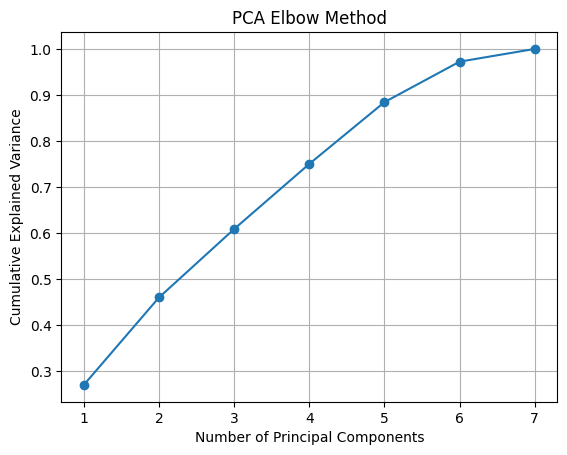

In [130]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_continuous)

pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Method')
plt.grid(True)
plt.show()

In [131]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


# 1. Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_continuous)

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# 3. Convert back to DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2","PC3","PC4","PC5","PC6"])

In [132]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.724318,-2.749223,0.924015,0.981150,-1.818112,0.031401
1,1.804907,-2.834272,0.925790,0.983207,-1.823970,-0.070815
2,1.421536,-2.999878,0.859694,1.043025,-1.811499,-0.174661
3,1.310929,-3.281386,-0.512500,-1.715091,-0.228602,-0.201404
4,1.525268,-3.226943,-0.478476,-1.743295,-0.237076,-0.180899
...,...,...,...,...,...,...
10789,-1.004913,-0.815866,1.586174,0.496942,0.152213,-1.944534
10790,-0.585506,-0.793469,1.723984,0.563459,0.082313,-2.000670
10791,-0.568127,-0.899665,1.714580,0.574228,0.079293,-2.113835
10792,-0.291487,-0.777235,1.762822,0.530884,0.070264,-2.035152


In [133]:
final_data = pd.concat([pca_df, X_boolean.reset_index(drop=True)], axis=1)

In [134]:
final_data

,PC1,PC2,PC3,PC4,PC5,PC6,Supertrend_Direction,high_liquidity
0,1.724318,-2.749223,0.924015,0.981150,-1.818112,0.031401,1,0
1,1.804907,-2.834272,0.925790,0.983207,-1.823970,-0.070815,1,0
2,1.421536,-2.999878,0.859694,1.043025,-1.811499,-0.174661,1,0
3,1.310929,-3.281386,-0.512500,-1.715091,-0.228602,-0.201404,1,0
4,1.525268,-3.226943,-0.478476,-1.743295,-0.237076,-0.180899,1,0
...,...,...,...,...,...,...,...,...
10789,-1.004913,-0.815866,1.586174,0.496942,0.152213,-1.944534,-1,0
10790,-0.585506,-0.793469,1.723984,0.563459,0.082313,-2.000670,-1,0
10791,-0.568127,-0.899665,1.714580,0.574228,0.079293,-2.113835,-1,0
10792,-0.291487,-0.777235,1.762822,0.530884,0.070264,-2.035152,-1,0


In [135]:
final_data.to_csv("C:/Users/vamsi/OneDrive/Desktop/Documents/studies/complete stock market predictor/Stock-Market-Predictor/project_root/data/Feature_Engineered_data.csv", index=False)

In [136]:
y.to_csv("C:/Users/vamsi/OneDrive/Desktop/Documents/studies/complete stock market predictor/Stock-Market-Predictor/project_root/data/Feature_Engineered_result.csv", index=False)